# Project 2 — Part 1: Perspective Warping (Step-by-step)

This notebook demonstrates the full Part 1 pipeline on a **single video frame** (and optionally scans for a good frame):

1. Load `reference`, `template`, and a `frame` from the video
2. Detect SIFT features and compute descriptors
3. Match descriptors (KNN) + Lowe ratio test
4. Estimate homography with RANSAC
5. Warp template into the frame and overlay it

Files expected:
- `data/reference.JPG`
- `data/template.JPG`
- `data/video_part1.mp4`



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def bgr_to_rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


def show(img_rgb, title=None, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()



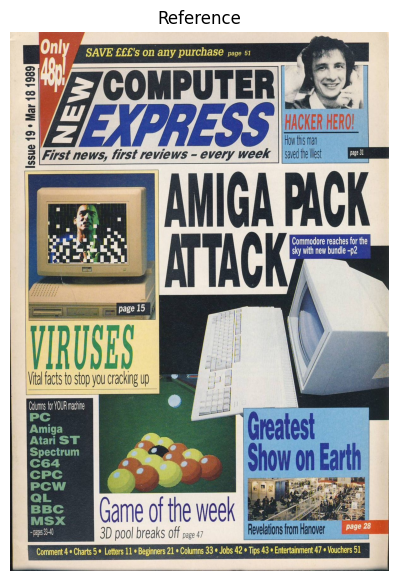

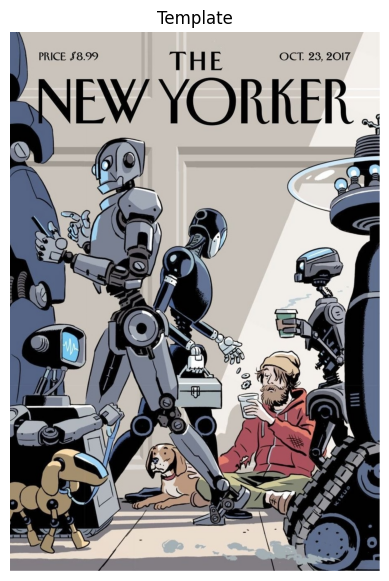

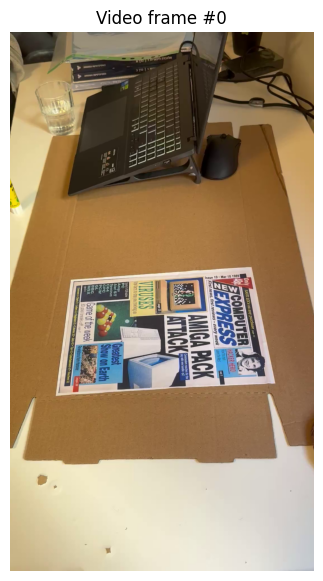

reference: (1711, 1200, 3)
template:  (1310, 897, 3)
frame:     (1920, 1080, 3)


In [2]:
# Inputs
REFERENCE_PATH = "data/reference.JPG"
TEMPLATE_PATH  = "data/template.JPG"
VIDEO_PATH     = "data/video_part1.mp4"

# Choose a frame to inspect (change this freely)
FRAME_IDX = 0

ref_bgr = cv2.imread(REFERENCE_PATH)
tmp_bgr = cv2.imread(TEMPLATE_PATH)
cap = cv2.VideoCapture(VIDEO_PATH)

assert ref_bgr is not None, f"Failed to read {REFERENCE_PATH}"
assert tmp_bgr is not None, f"Failed to read {TEMPLATE_PATH}"
assert cap.isOpened(), f"Failed to open {VIDEO_PATH}"

cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_IDX)
ok, frame_bgr = cap.read()
assert ok, f"Failed to read frame {FRAME_IDX}"

ref_rgb = bgr_to_rgb(ref_bgr)
tmp_rgb = bgr_to_rgb(tmp_bgr)
frame_rgb = bgr_to_rgb(frame_bgr)

show(ref_rgb, "Reference")
show(tmp_rgb, "Template")
show(frame_rgb, f"Video frame #{FRAME_IDX}")

print("reference:", ref_bgr.shape)
print("template: ", tmp_bgr.shape)
print("frame:    ", frame_bgr.shape)



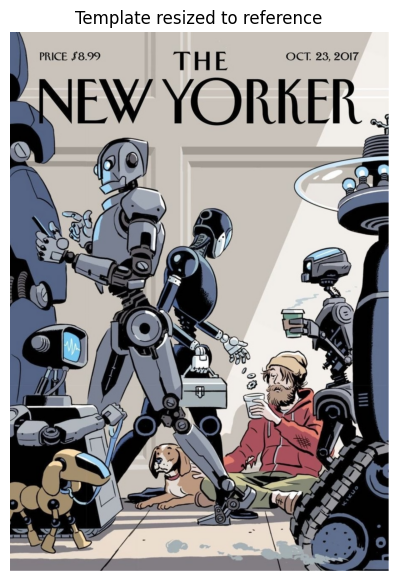

template resized: (1711, 1200, 3)


In [3]:
# Step 0: make template use the same pixel coordinate system as the reference
h_ref, w_ref = ref_bgr.shape[:2]
tmp_rs = cv2.resize(tmp_bgr, (w_ref, h_ref), interpolation=cv2.INTER_AREA)

show(bgr_to_rgb(tmp_rs), "Template resized to reference")
print("template resized:", tmp_rs.shape)



#kp reference: 9217 des: (9217, 128)
#kp frame:     4895 des: (4895, 128)


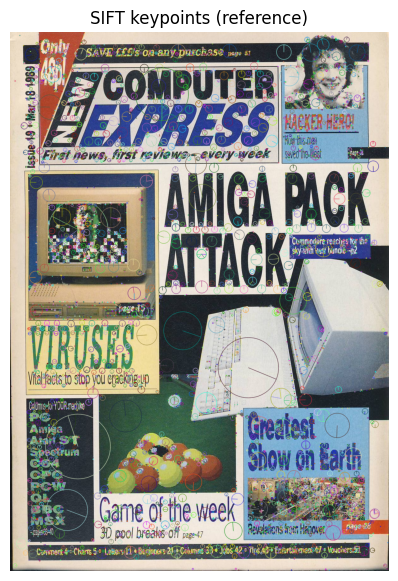

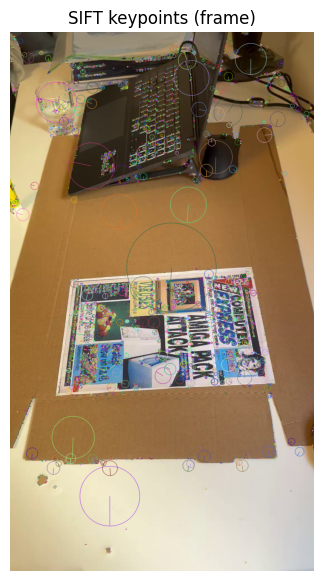

In [4]:
# Step 1: SIFT features (keypoints + descriptors)
assert hasattr(cv2, "SIFT_create"), "SIFT is not available. Install opencv-contrib-python."

sift = cv2.SIFT_create()

ref_gray = cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2GRAY)
frame_gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

kp_ref, des_ref = sift.detectAndCompute(ref_gray, None)
kp_fr, des_fr = sift.detectAndCompute(frame_gray, None)

print("#kp reference:", len(kp_ref), "des:", None if des_ref is None else des_ref.shape)
print("#kp frame:    ", len(kp_fr), "des:", None if des_fr is None else des_fr.shape)

ref_kp_img = cv2.drawKeypoints(ref_rgb, kp_ref, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fr_kp_img = cv2.drawKeypoints(frame_rgb, kp_fr, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show(ref_kp_img, "SIFT keypoints (reference)")
show(fr_kp_img, "SIFT keypoints (frame)")



#good matches: 1095


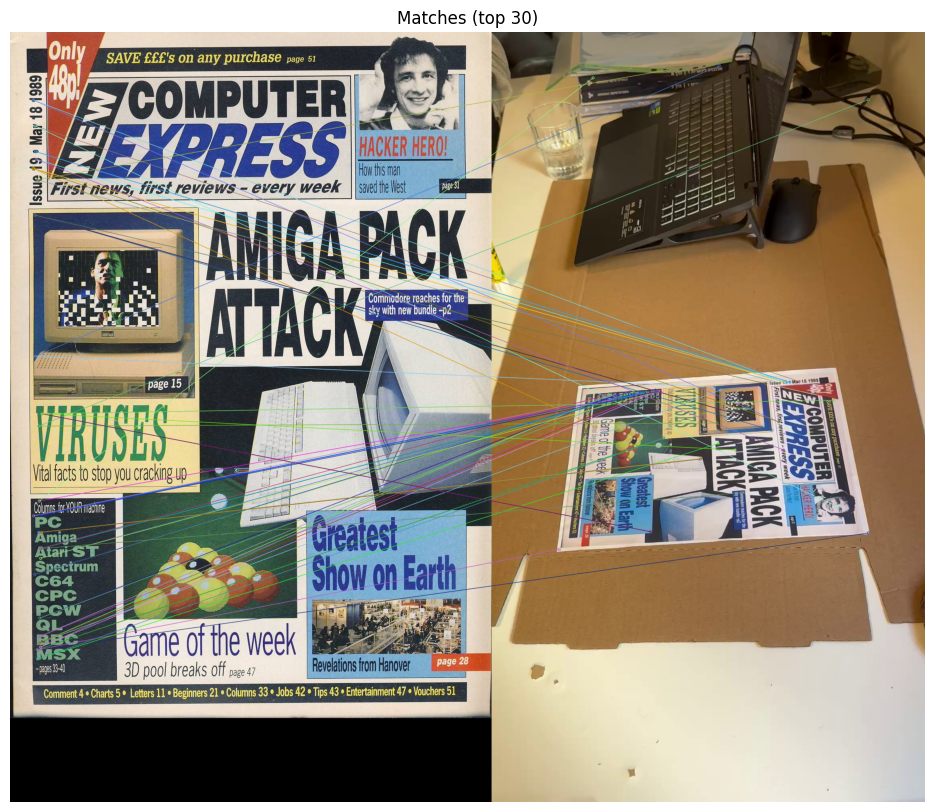

In [5]:
# Step 2: descriptor matching (KNN) + Lowe ratio test
RATIO = 0.7

bf = cv2.BFMatcher()  # SIFT uses L2
pairs = bf.knnMatch(des_ref, des_fr, k=2)

good_pairs = []
for p in pairs:
    if len(p) != 2:
        continue
    if p[0].distance / p[1].distance < RATIO:
        good_pairs.append(p)

good = [p[0] for p in good_pairs]
print("#good matches:", len(good))

matches_img = cv2.drawMatchesKnn(
    ref_rgb, kp_ref,
    frame_rgb, kp_fr,
    good_pairs[:30],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
show(matches_img, "Matches (top 30)", figsize=(20, 10))



#inliers: 809 / 1095
H:
 [[-6.90484362e-02 -3.62954746e-01  8.50810852e+02]
 [ 1.56407196e-01  3.20916514e-02  8.48118254e+02]
 [-1.42103185e-04  1.06710453e-05  1.00000000e+00]]


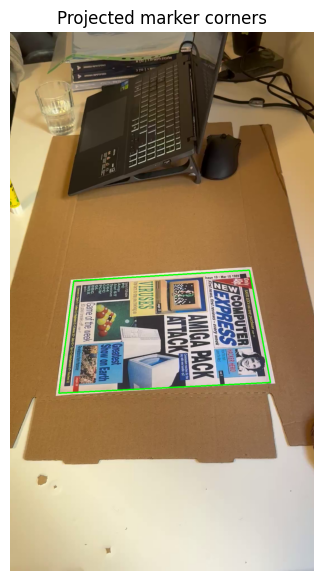

In [6]:
# Step 3: homography estimation with RANSAC
MIN_MATCHES = 30
RANSAC_THRESH = 3.5

if len(good) < MIN_MATCHES:
    raise RuntimeError("Not enough matches for homography. Try another FRAME_IDX or increase RATIO.")

src = np.float32([kp_ref[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst = np.float32([kp_fr[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

H, inlier_mask = cv2.findHomography(src, dst, cv2.RANSAC, RANSAC_THRESH)
assert H is not None and inlier_mask is not None

inliers = int(inlier_mask.sum())
print("#inliers:", inliers, "/", len(good))
print("H:\n", H)

# Project reference corners into the frame
ref_corners = np.float32([[0, 0], [w_ref - 1, 0], [w_ref - 1, h_ref - 1], [0, h_ref - 1]]).reshape(-1, 1, 2)
proj = cv2.perspectiveTransform(ref_corners, H)

frame_poly = frame_rgb.copy()
cv2.polylines(frame_poly, [proj.astype(int)], True, (0, 255, 0), 3)
show(frame_poly, "Projected marker corners")



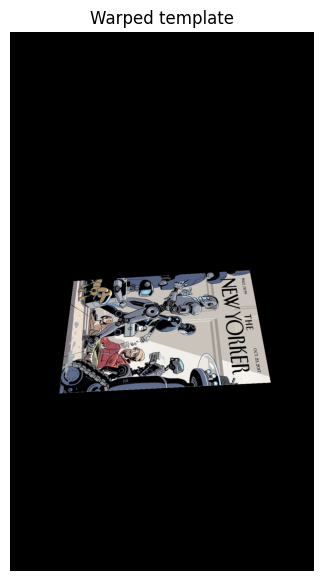

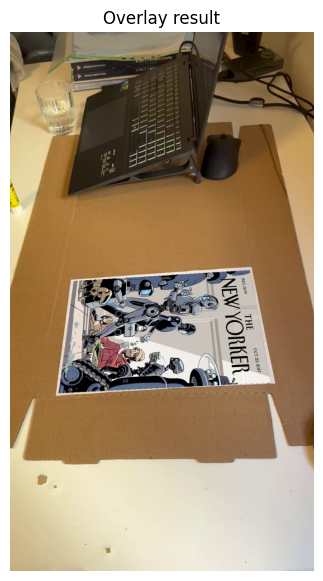

In [7]:
# Step 4: warp template into the frame + overlay
# Important: do not use "black pixels" as transparency. Build a geometric mask instead.

h_fr, w_fr = frame_bgr.shape[:2]

warped = cv2.warpPerspective(tmp_rs, H, (w_fr, h_fr))

# Geometric mask: warp an all-ones image from template coordinates into the frame.
ones = np.ones((h_ref, w_ref), dtype=np.uint8) * 255
mask = cv2.warpPerspective(ones, H, (w_fr, h_fr))

out_bgr = frame_bgr.copy()
out_bgr[mask > 0] = warped[mask > 0]

show(bgr_to_rgb(warped), "Warped template")
show(bgr_to_rgb(out_bgr), "Overlay result")



In [8]:
# Optional: scan a few frames to find one with many inliers
STEP = 30
MAX_FRAMES = 300

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
if num_frames == 0:
    num_frames = MAX_FRAMES

indices = list(range(0, min(num_frames, MAX_FRAMES), STEP))

results = []
for idx in indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ok, fr = cap.read()
    if not ok:
        continue

    fr_gray = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(fr_gray, None)
    if des is None:
        results.append((idx, 0, 0))
        continue

    pairs = bf.knnMatch(des_ref, des, k=2)
    good = []
    for p in pairs:
        if len(p) != 2:
            continue
        if p[0].distance / p[1].distance < RATIO:
            good.append(p[0])

    if len(good) < MIN_MATCHES:
        results.append((idx, len(good), 0))
        continue

    src = np.float32([kp_ref[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst = np.float32([kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    H, inlier_mask = cv2.findHomography(src, dst, cv2.RANSAC, RANSAC_THRESH)
    inliers = int(inlier_mask.sum()) if inlier_mask is not None else 0

    results.append((idx, len(good), inliers))

results = sorted(results, key=lambda x: x[2], reverse=True)
print("Top frames (idx, good_matches, inliers):")
for r in results[:10]:
    print(r)



Top frames (idx, good_matches, inliers):
(30, 1096, 826)
(0, 1095, 809)
(120, 1000, 738)
(60, 1028, 720)
(150, 997, 713)
(90, 848, 632)
(180, 880, 558)
(210, 708, 473)
(240, 629, 283)
(270, 432, 236)
